# Filter Bad Images

In [1]:
from pathlib import Path

# Directory containing images
image_dir = Path('../../data/external/nexet/input_A')
output_dir = Path('../../data/external/nexet/filter/input_A')

In [2]:
def check_dirs(image_dir, output_dir):
    if not image_dir.exists():
        raise FileNotFoundError(f"Directory {image_dir} not found. Please download the dataset.")

    output_dir.mkdir(parents=True, exist_ok=True)
    closest_dir = output_dir / 'closest'
    closest_dir.mkdir(parents=True, exist_ok=True)
    clusters_dir = output_dir / 'clusters'
    clusters_dir.mkdir(parents=True, exist_ok=True)

check_dirs(image_dir, output_dir)

## Extract Features in a ResNet18

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from tqdm import tqdm
import pandas as pd

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet18 model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the last classification layer
model = model.to(device)  # Move model to GPU if available
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
def extract_features(folder_path, model, device):

    def _extract_features(img_path, model, device):
        img = Image.open(img_path).convert('RGB')
        img_data = preprocess(img)
        img_data = img_data.unsqueeze(0)  # Add batch dimension
        img_data = img_data.to(device)  # Move data to GPU if available
        with torch.no_grad():
            features = model(img_data)
        return features.flatten().cpu().numpy()  # Move features back to CPU and convert to numpy

    # Extract features for all images
    features = []
    image_paths = []
    for img_path in tqdm(list(folder_path.glob('*'))):
        image_paths.append(img_path)
        features.append(_extract_features(img_path, model, device))

    return np.array(features), pd.DataFrame({'image_path': image_paths})

In [5]:
features, df_img = extract_features(image_dir, model, device)
df_img.to_csv(output_dir / 'images.csv', index=True)

100%|██████████| 4883/4883 [00:20<00:00, 236.02it/s]


## Remove Similar Images

In [6]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [7]:
def find_closest_images(features, max_pairs=200):
    # Calculate pairwise distances between all images
    pairwise_distances = squareform(pdist(features, 'euclidean'))

    # Set to infinity to ignore self-pairs and already paired images
    upper_triangle_indices = np.triu_indices(pairwise_distances.shape[0], k=0)
    pairwise_distances[upper_triangle_indices] = np.inf

    # Find the indices of the closest pairs
    closest_pairs = []
    img_distances = []

    for _ in tqdm(range(max_pairs)):
        min_dist_idx = np.unravel_index(np.argmin(pairwise_distances), pairwise_distances.shape)
        if np.isinf(pairwise_distances[min_dist_idx]):
            break
        closest_pairs.append(min_dist_idx)
        img_distances.append(pairwise_distances[min_dist_idx])
        pairwise_distances[min_dist_idx] = np.inf

    return closest_pairs, img_distances

def plot_distances(img_distances, output_dir, figsize=(8, 3)):
    _, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].plot(img_distances, c='b', linewidth=1.2)
    axes[0].set_xlabel('Closest Pair Index')
    axes[0].set_ylabel('Distance')

    delta = np.array(img_distances[1:]) - np.array(img_distances[:-1])
    axes[1].plot(delta, c='r', linewidth=1.2)
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Closest Pair Index')
    axes[1].set_ylabel('Delta Distance')

    plt.suptitle('Closest Images')
    plt.tight_layout()
    plt.savefig(output_dir / 'closest_pair_distances.png')
    plt.show()
    plt.close()

100%|██████████| 200/200 [00:02<00:00, 80.31it/s]


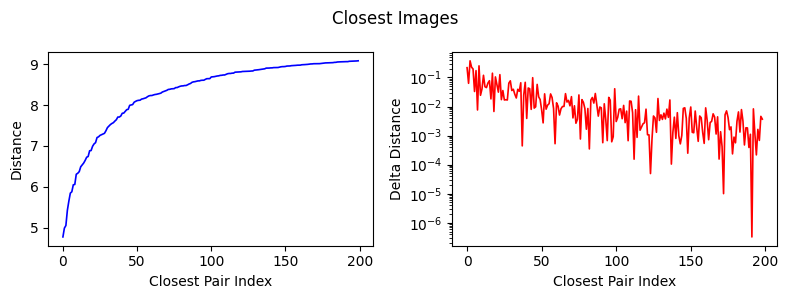

In [8]:
closest_pairs, img_distances = find_closest_images(features, max_pairs=200)
plot_distances(img_distances, output_dir)

In [9]:
def save_closest_images(closest_pairs, img_paths, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    png_files = list(output_dir.glob('*.png'))
    for png_file in png_files:
        png_file.unlink()

    for i  in tqdm(range(len(closest_pairs))):
        idx1, idx2 = closest_pairs[i]
        _, axes = plt.subplots(1, 2, figsize=(12, 6))

        img1 = Image.open(img_paths[idx1])
        img2 = Image.open(img_paths[idx2])

        axes[0].imshow(img1)
        axes[0].axis('off')
        axes[0].set_title(f'Image {idx1}')

        axes[1].imshow(img2)
        axes[1].axis('off')
        axes[1].set_title(f'Image {idx2}')

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.savefig(output_dir / f'closest_pair_{i+1}.png')
        plt.close()

save_closest_images(closest_pairs, df_img['image_path'], output_dir / 'closest')

100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


In [10]:
def show_original_image(img_n):
    path_mod = df_img['image_path'][img_n]
    print(path_mod.name)

    path_orig = Path('../../no_sync/nexet/nexet/nexet_2017_1') / path_mod.name

    img = Image.open(path_orig)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    plt.close()

    img = Image.open(path_mod)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    plt.close()

# show_original_image(3144)

In [11]:
def closest_pairs_mask(closest_pairs, num_images):
    indices_to_remove = set()
    for _, idx2 in closest_pairs:
        indices_to_remove.add(int(idx2))

    mask = np.ones(num_images, dtype=bool)
    mask[list(indices_to_remove)] = False

    return mask

In [12]:
closest_mask = closest_pairs_mask(closest_pairs[:93], df_img.shape[0])
df_img['repeat'] = closest_mask
df_img.to_csv(output_dir / 'images.csv', index=True)

## Group Similar Images

### Clustering

In [13]:
from sklearn.cluster import KMeans
import pandas as pd
from scipy.spatial.distance import cdist

In [14]:
def plot_elbow_method(features, max_k=30, output_dir=None):
    distortions = []
    K = range(1, max_k+1)
    for k in tqdm(K):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(features)
        distortions.append(sum(np.min(cdist(features, kmeans.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

    plt.plot(K, distortions, 'bo-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method')
    if output_dir is not None:
        plt.savefig(output_dir / 'image_clusters_best_k.png')
    plt.show()
    plt.close()

def cluster_images(features, num_clusters=20):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    labels = kmeans.fit_predict(features)
    return labels

def plot_cluster_hist(clusters, num_clusters=20, title=None, output_dir=None):
    _, axes = plt.subplots(1, 1, figsize=(6, 4))
    bins = np.arange(num_clusters+1) - 0.5
    axes.hist(clusters, bins=bins, color='b', edgecolor='k', alpha=0.7)

    bin_centers = bins[:-1] + 0.5
    axes.set_xticks(bin_centers)
    if len(bins) > 21:
        axes.set_xticklabels([int(i) if i%2==0 else '' for i in bin_centers])
    else:
        axes.set_xticklabels([int(i) for i in bin_centers])

    axes.set_xlabel('Cluster Number')
    axes.set_ylabel('Number of Images')
    if title is None:
        axes.set_title('Cluster Image Count')
    else:
        axes.set_title(title)
    plt.tight_layout()
    if output_dir is not None:
        plt.savefig(output_dir / 'image_clusters_hist.png')
    plt.show()
    plt.close()

100%|██████████| 30/30 [00:03<00:00,  9.37it/s]


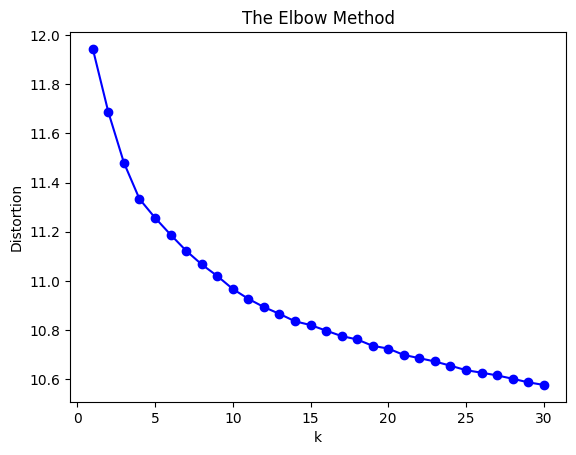

In [15]:
plot_elbow_method(features[df_img['repeat']])

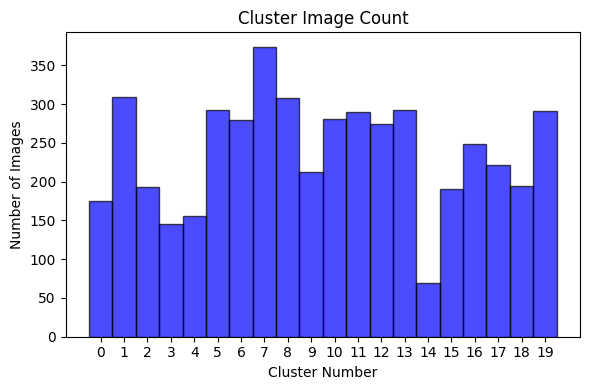

In [16]:
num_clusters=20
labels = cluster_images(features[df_img['repeat']], num_clusters=num_clusters)
plot_cluster_hist(labels, num_clusters=num_clusters, output_dir=output_dir)

df_img.loc[df_img['repeat'], 'cluster'] = labels
df_img.loc[~df_img['repeat'], 'cluster'] = -1
df_img['cluster'] = df_img['cluster'].astype(int)
df_img.to_csv(output_dir / 'images.csv', index=True)

In [17]:
def save_clusters_samples(labels, img_paths, output_dir, max_images=16):
    output_dir.mkdir(parents=True, exist_ok=True)
    png_files = list(output_dir.glob('*.png'))
    for png_file in png_files:
        png_file.unlink()

    for subfolder in output_dir.iterdir():
        if subfolder.is_dir() and subfolder.name.startswith('subcluster'):
            for item in subfolder.iterdir():
                if item.is_file():
                    item.unlink()
                elif item.is_dir():
                    item.rmdir()
            subfolder.rmdir()

    labels = np.array(labels)
    img_paths = np.array(img_paths)

    for i in tqdm(range(max(labels)+1)):
        cluster_indices = np.where(labels == i)[0]
        num_images = min(len(cluster_indices), max_images)
        grid_size = int(np.ceil(np.sqrt(num_images)))

        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        axes = [axes] if num_images == 1 else axes.flatten()
        fig.suptitle(f'Cluster {i}', fontsize=16, fontweight='bold')

        cluster_indices = cluster_indices[:num_images]
        np.random.shuffle(cluster_indices)
        for ax, img_index in zip(axes, cluster_indices):
            img_path = img_paths[img_index]
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.axis('off')

        for ax in axes[num_images:]:
            ax.axis('off')

        plt.tight_layout()
        plt.savefig(output_dir / f'cluster_{i}.png')
        plt.close()

In [18]:
save_clusters_samples(df_img['cluster'], df_img['image_path'], output_dir / 'clusters', max_images=36)

100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


### Further Analyze Some Clusters

In [19]:
problematic_clusters = [14, 15, 18]

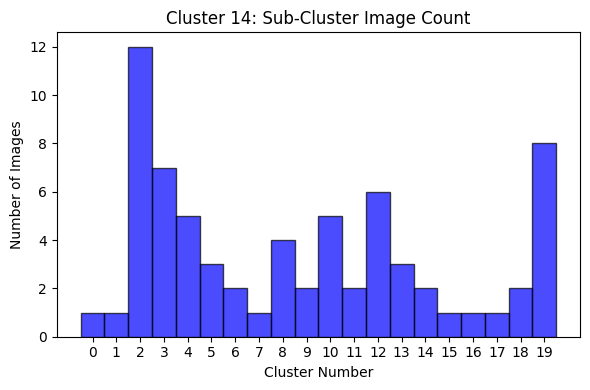

100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


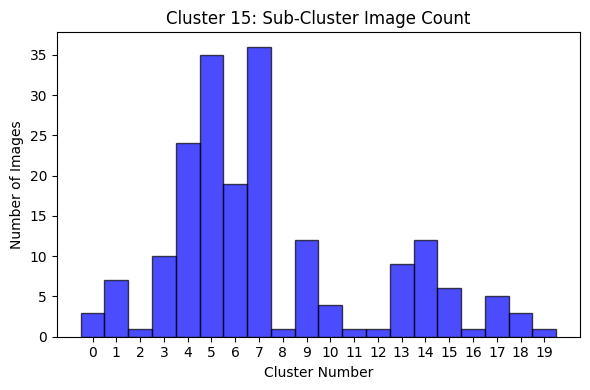

100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


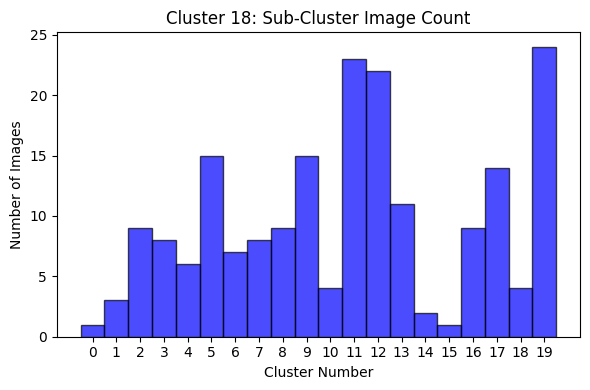

100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


In [20]:
df_img['subcluster'] = -1

for c in problematic_clusters:
    num_sub_clusters=20

    filter_ = (df_img['cluster'] == c)
    sub_labels = cluster_images(features[filter_], num_clusters=num_sub_clusters)
    plot_cluster_hist(sub_labels, num_clusters=num_sub_clusters, title=f"Cluster {c}: Sub-Cluster Image Count")

    df_img.loc[filter_, 'subcluster'] = sub_labels
    save_clusters_samples(df_img[filter_]['subcluster'], df_img[filter_]['image_path'], output_dir / 'clusters' / f'subcluster_{c}')

df_img.to_csv(output_dir / 'images.csv', index=True)

### Define Clusters to Remove

In [21]:
remove_clusters = [
    (14,0),
    (14,2),
    (14,4),
    (14,6),
    (14,10),
    (14,13),
    (14,14),
    (14,16),
    (14,19),

    (15,0),
    (15,11),
    (15,12),
    (15,15),
    (15,19),

    (18,4),
    (18,14),
    (18,15),
    ]

In [22]:
def build_keep_mask(df, remove_clusters):
    keep = np.ones(df.shape[0], dtype=bool)
    for cluster in remove_clusters:
        if isinstance(cluster, int):
            filter_ = (df['cluster'] == cluster)
        else:
            filter_ = (df['cluster'] == cluster[0]) & (df['subcluster'] == cluster[1])
        keep = keep & ~filter_
    return keep

In [23]:
df_img['keep'] = build_keep_mask(df_img, remove_clusters)
df_img.loc[~df_img['repeat'], 'keep'] =  False
df_img.to_csv(output_dir / 'images.csv', index=True)
df_img['keep'].value_counts()

keep
True     4737
False     146
Name: count, dtype: int64

### Remove Filtered Images from DB

In [ ]:
def remove_images_from_lists(image_dir, df, overwrite=False):
    image_paths = df[df['keep']]['image_path'].values
    for file_type in ['_train','_test','_all']:
        file_path = image_dir.parent / f'{image_dir.name}{file_type}.csv'
        df_db = pd.read_csv(file_path)
        file_name_col = df_db.columns[0]
        df_db['image_path'] = image_dir / df_db[file_name_col]
        df_db['keep'] = df_db['image_path'].apply(lambda x: x in image_paths)
        if not overwrite:
            file_path = file_path.parent / f'{file_path.stem}_filtered{file_path.suffix}'
        df_db.loc[df_db['keep']][file_name_col].to_csv(file_path, index=False)
        print(f'Removed {(~df_db["keep"]).sum()} entries in {file_path.name}')

In [25]:
remove_images_from_lists(image_dir, df_img)

Removed 118 entries in input_A_train_filtered.csv
Removed 28 entries in input_A_test_filtered.csv


## Apply to Another Folder

In [26]:
image_dir = Path('../../data/external/nexet/input_B')
output_dir = Path('../../data/external/nexet/filter/input_B')

check_dirs(image_dir, output_dir)

features, df_img = extract_features(image_dir, model, device)
df_img.to_csv(output_dir / 'images.csv', index=True)

100%|██████████| 4374/4374 [00:19<00:00, 225.28it/s]


100%|██████████| 200/200 [00:01<00:00, 102.96it/s]


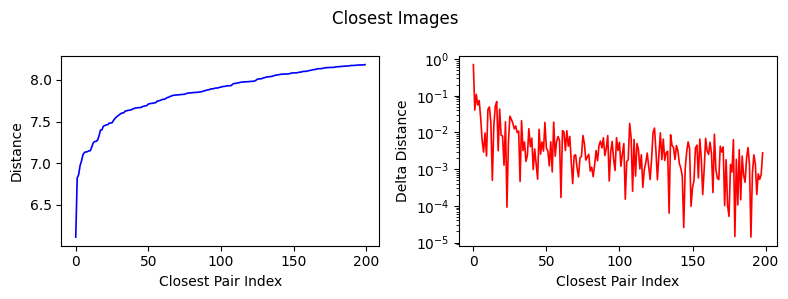

100%|██████████| 200/200 [00:33<00:00,  5.94it/s]


In [27]:
closest_pairs, img_distances = find_closest_images(features, max_pairs=200)
plot_distances(img_distances, output_dir)
save_closest_images(closest_pairs, df_img['image_path'], output_dir / 'closest')

In [28]:
closest_mask = closest_pairs_mask(closest_pairs[:0], df_img.shape[0])
df_img['repeat'] = closest_mask
df_img.to_csv(output_dir / 'images.csv', index=True)

100%|██████████| 30/30 [00:03<00:00,  9.55it/s]


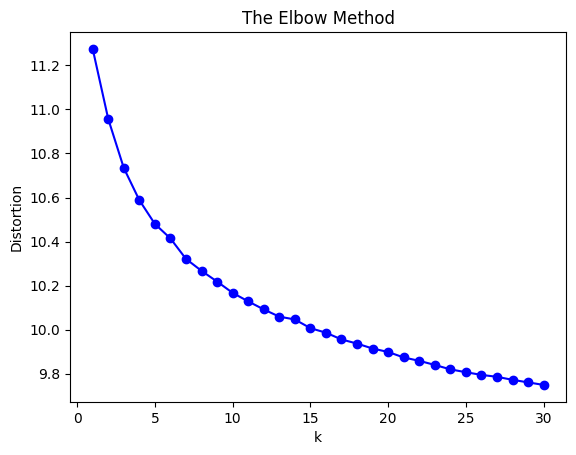

In [29]:
plot_elbow_method(features[df_img['repeat']])

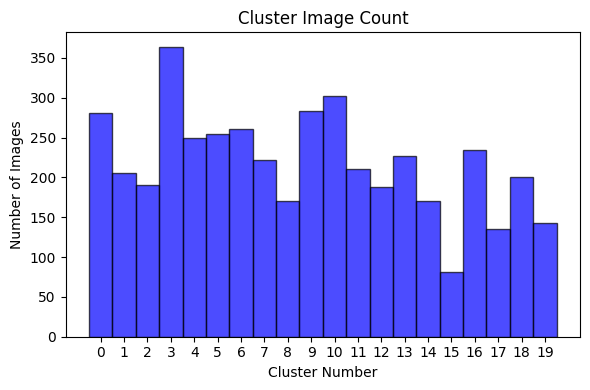

100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


In [31]:
num_clusters=20
labels = cluster_images(features[df_img['repeat']], num_clusters=num_clusters)
plot_cluster_hist(labels, num_clusters=num_clusters, output_dir=output_dir)

df_img.loc[df_img['repeat'], 'cluster'] = labels
df_img.loc[~df_img['repeat'], 'cluster'] = -1
df_img['cluster'] = df_img['cluster'].astype(int)
df_img.to_csv(output_dir / 'images.csv', index=True)

save_clusters_samples(df_img['cluster'], df_img['image_path'], output_dir / 'clusters', max_images=36)

In [32]:
problematic_clusters = [15, 17]

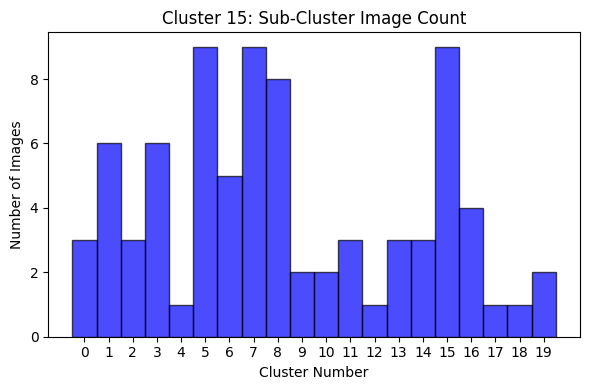

100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


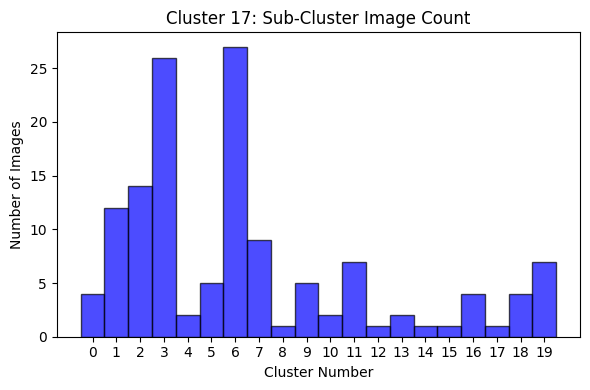

100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


In [33]:
df_img['subcluster'] = -1

for c in problematic_clusters:
    num_sub_clusters=20

    filter_ = (df_img['cluster'] == c)
    sub_labels = cluster_images(features[filter_], num_clusters=num_sub_clusters)
    plot_cluster_hist(sub_labels, num_clusters=num_sub_clusters, title=f"Cluster {c}: Sub-Cluster Image Count")

    df_img.loc[filter_, 'subcluster'] = sub_labels
    save_clusters_samples(df_img[filter_]['subcluster'], df_img[filter_]['image_path'], output_dir / 'clusters' / f'subcluster_{c}')

In [34]:
remove_clusters = [
    (15),

    (17),
    ]

In [35]:
df_img['keep'] = build_keep_mask(df_img, remove_clusters)
df_img.loc[~df_img['repeat'], 'keep'] =  False
df_img.to_csv(output_dir / 'images.csv', index=True)
df_img['keep'].value_counts()

keep
True     4158
False     216
Name: count, dtype: int64

In [36]:
remove_images_from_lists(image_dir, df_img)

Removed 183 entries in input_B_train_filtered.csv
Removed 33 entries in input_B_test_filtered.csv
